In [ ]:
# Import necessary libaries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from requests import get

<h1 align='center'>Time Series Data</h1>

<p>Download data from Johns Hopkins University (JHU) Center for Systems Science and Engineering's (CSSE) GitHub repository</p>

In [8]:
cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

In [9]:
recovs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [10]:
deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [11]:
# Read data into data frame
df_cases = pd.read_csv(cases)
df_recovs = pd.read_csv(recovs)
df_deaths = pd.read_csv(deaths)

In [12]:
# Extract confirmed cases data for Nigeria
df_cases.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_cases.set_index('Country/Region', inplace=True)
df_cases = df_cases.loc['Nigeria']
df_cases = pd.DataFrame(df_cases)
df_cases.columns = ['Cases']
df_cases = df_cases.loc['2/28/20':]

In [13]:
# Extract recoveries data for Nigeria
df_recovs.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_recovs.set_index('Country/Region', inplace=True)
df_recovs = df_recovs.loc['Nigeria']
df_recovs = pd.DataFrame(df_recovs)
df_recovs.columns = ['Recoveries']
df_recovs = df_recovs.loc['2/28/20':]

In [14]:
# Extract death data for Nigeria
df_deaths.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_deaths.set_index('Country/Region', inplace=True)
df_deaths = df_deaths.loc['Nigeria']
df_deaths = pd.DataFrame(df_deaths)
df_deaths.columns = ['Deaths']
df_deaths = df_deaths.loc['2/28/20':]

In [15]:
# Merge cases, recoveriies and death data into one data frame
time_series = pd.concat([df_cases, df_recovs, df_deaths], axis=1, ignore_index=False)

In [16]:
# Rename columns
time_series.reset_index(inplace=True)
time_series.columns = ['Time', 'Cases', 'Recoveries', 'Deaths']

In [17]:
# Set time column type to datetime

#date = pd.date_range("1 22 2020", periods=time_series.shape[0], freq="D", name="date")
time_series['Time'] = pd.to_datetime(time_series['Time'], errors='coerce')

In [18]:
# Make time column index of the data frame
time_series.set_index('Time', inplace=True)

In [19]:
time_series = time_series.asfreq('D', method = 'ffill')

In [20]:
time_series.head()

,Cases,Recoveries,Deaths
Time,,,
2020-02-28,1,0,0
2020-02-29,1,0,0
2020-03-01,1,0,0
2020-03-02,1,0,0
2020-03-03,1,0,0


In [21]:
# Export time series data to csv
time_series.to_csv('time_series.csv')

In [25]:
# Import libraries for plotting
import seaborn as sns
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

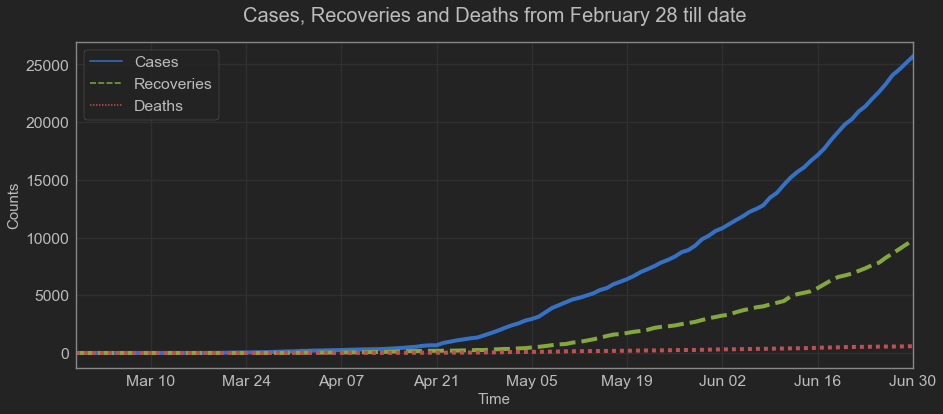

In [28]:
fig, ax = plt.subplots(figsize=(15, 6))
jtplot.style(theme='monokai', context='notebook', fscale=1.5, spines=True)
sns.lineplot(data=time_series, ax=ax, linewidth=4)
ax.set_title('Cases, Recoveries and Deaths from February 28 till date', fontdict={'fontsize': '20', 'fontweight' : '3'}, pad=20)
ax.set_ylabel('Counts', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlabel('Time', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlim(time_series.index[0], time_series.index[-1])

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# Format x-tick labels to show at 2 weeks interval
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# Save figure
plt.savefig('line-plot.png', dpi=150)

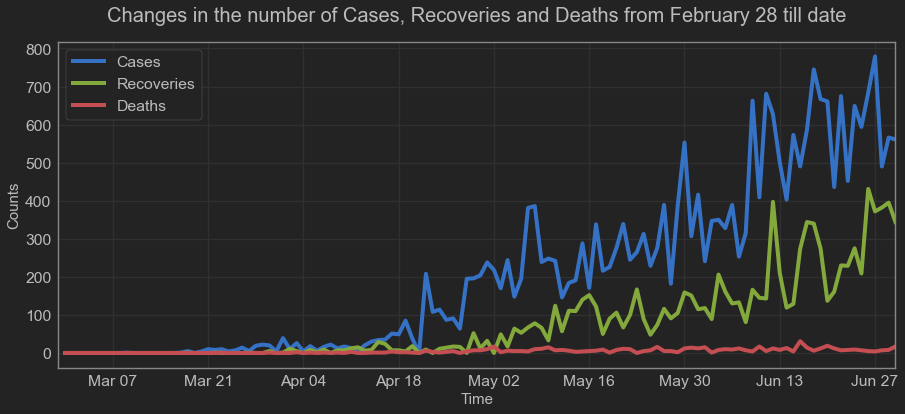

In [27]:
fig, ax = plt.subplots(figsize=(15, 6))
jtplot.style(theme='monokai', context='notebook', fscale=1.5, spines=True)
time_series.diff().plot(ax=ax, linewidth=4)
ax.set_title('Changes in the number of Cases, Recoveries and Deaths from February 28 till date', fontdict={'fontsize': '20', 'fontweight' : '3'}, pad=20)
ax.set_ylabel('Counts', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlabel('Time', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlim(time_series.index[0], time_series.index[-1])

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# Format x-tick labels to show at 2 weeks interval
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# Save figure
plt.savefig('time-lag.png', dpi=150)